In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.bert_conf
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_about_abs'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.49362244897959184
MALE 0.984375
FEMALE 0.0225 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5202020202020202
MALE 0.9902676399026764
FEMALE 0.013123359580052493 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5202086049543677
MALE 0.9772727272727273
FEMALE 0.03234501347708895 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.681216700359504 	 Validation loss: 0.6797408219111167 	 
  1%|          | 574/57400 [01:39<2:32:04,  6.23it/s]
Epoch 2 	 Training loss: 0.6717321011870581 	 Validation loss: 0.6665090120444863 	 
  2%|▏         | 1148/57400 [03:18<2:44:00,  5.72it/s]
Epoch 3 	 Training loss: 0.6507888257711191 	 Validation loss: 0.6273309214640472 	 
  3%|▎         | 1722/57400 [04:57<2:31:44,  6.12it/s]
Epoch 4 	 Training loss: 0.5851014794892135 	 Validation loss: 0.5288999100862923 	 
  4%|▍         | 2296/57400 [06:36<2:28:50,  6.17it/s]
Epoch 5 	 Training loss: 0.4907847197940541 	 Validation loss: 0.4455516606064166 	 
  5%|▌         | 2870/57400 [08:14<2:29:15,  6.09it/s]
Epoch 6 	 Training loss: 0.4336690688278617 	 Validation loss: 0.4031126281972659 	 
  6%|▌         | 3444/57400 [09:53<2:12:29,  6.79it/s]
Epoch 7 	 Training loss: 0.40405064447416245 	 Validation loss: 0.3804406220630064 	 
  7%|▋         | 4018/57400 [11:30<2:22:49,  6.23it/s]
Epoch 8 	 Training lo

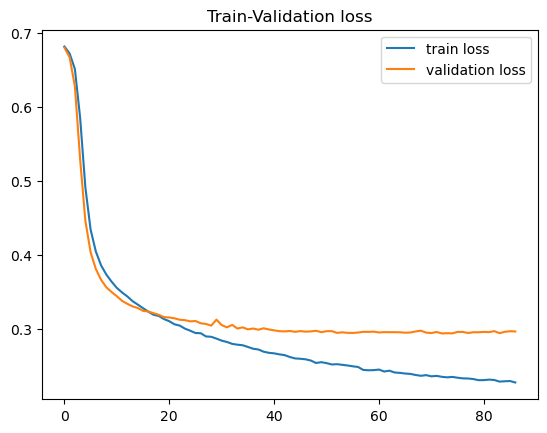

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8558673469387755
MALE 0.8697916666666666
FEMALE 0.8425 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6856060606060606
MALE 0.7031630170316302
FEMALE 0.6666666666666666 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.681877444589309
MALE 0.702020202020202
FEMALE 0.660377358490566 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_to_abs'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6954724291268126 	 Validation loss: 0.6923597606561952 	 
  1%|          | 574/57400 [01:29<2:35:09,  6.10it/s]
Epoch 2 	 Training loss: 0.6950350187796749 	 Validation loss: 0.6937920531984103 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [02:59<2:16:49,  6.85it/s]
Epoch 3 	 Training loss: 0.6945310842492439 	 Validation loss: 0.6929561839265338 	 
  3%|▎         | 1722/57400 [04:28<2:24:42,  6.41it/s]
Epoch 4 	 Training loss: 0.6942335874984489 	 Validation loss: 0.6940407621658454 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [05:58<2:26:13,  6.28it/s]
Epoch 5 	 Training loss: 0.6940571338665195 	 Validation loss: 0.6942763075990191 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [07:28<2:22:02,  6.40it/s]
Epoch 6 	 Training loss: 0.6941742910533001 	 Validation loss: 0.6937854077856419 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [08:57<2:10:44,  6.88it/s]
Epoch 7 	 Training loss: 0.69395623369084 	 V

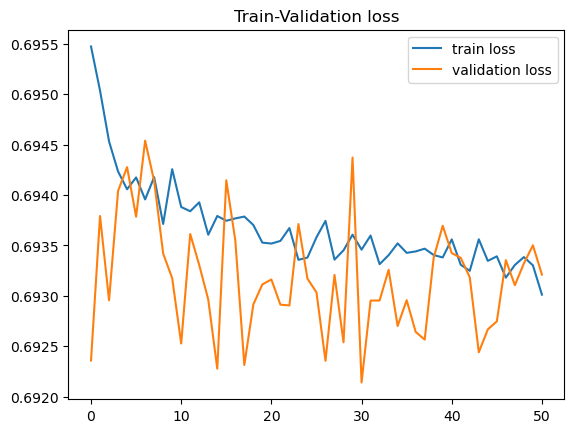

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5076530612244898
MALE 0.15104166666666666
FEMALE 0.85 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5113636363636364
MALE 0.17274939172749393
FEMALE 0.8766404199475065 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.48239895697522817
MALE 0.13636363636363635
FEMALE 0.8517520215633423 



# AS

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_as_abs'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6953937690640161 	 Validation loss: 0.6949668961056208 	 
  1%|          | 574/57400 [01:24<2:14:50,  7.02it/s]
Epoch 2 	 Training loss: 0.6945552002469837 	 Validation loss: 0.6936671127707271 	 
  2%|▏         | 1148/57400 [02:50<2:08:42,  7.28it/s]
Epoch 3 	 Training loss: 0.6943750897558724 	 Validation loss: 0.6932668140379049 	 
  3%|▎         | 1722/57400 [04:15<2:20:31,  6.60it/s]
Epoch 4 	 Training loss: 0.6941549585879057 	 Validation loss: 0.6939883555396128 	 
  4%|▍         | 2296/57400 [05:39<2:13:02,  6.90it/s]
Epoch 5 	 Training loss: 0.6939874531292334 	 Validation loss: 0.6926764027547028 	 
  5%|▌         | 2870/57400 [07:04<1:48:40,  8.36it/s]
Epoch 6 	 Training loss: 0.6939075714827415 	 Validation loss: 0.6929175944651588 	 
  6%|▌         | 3444/57400 [08:29<2:03:08,  7.30it/s]
Epoch 7 	 Training loss: 0.6936643648022974 	 Validation loss: 0.6936032933703924 	 
  7%|▋         | 4018/57400 [09:53<2:04:45,  7.13it/s]
Epoch 8 	 Training lo

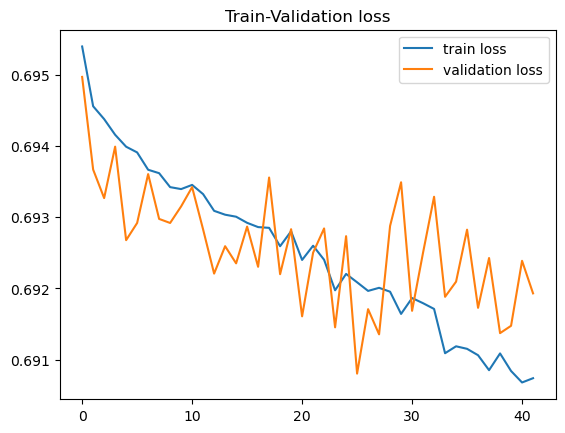

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [17]:
save_path='m1_dep_bert_as_abs'
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6352040816326531
MALE 0.40625
FEMALE 0.855 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.577020202020202
MALE 0.3746958637469586
FEMALE 0.7952755905511811 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5945241199478487
MALE 0.3611111111111111
FEMALE 0.8436657681940701 

